## Circuit constructions

This notebook demonstrates the following functions of ``pygrnd.qc.circuitConstructor`` in Pygrnd:
- ``decomposer``: decompose a general unitary gate into uncontrolled and controlled 1-qubit gates
- ``circuitStateVector``: construct a circuit for the preparation of a state vector 

The methods are implementations of algorithms of the following paper: 
A. Barenco, C. Bennett, R. Cleve, D. DiVincenzo, N. Margolus, P. Shor, T. Sleator, J. Smolin, H. Weinfurter: "Elementary gates for quantum computation", Physical Review A52, 3457 (1995).

In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, execute
from qiskit.extensions import UnitaryGate
import numpy as np
import math
import random
import pygrnd
from pygrnd.qc.circuitConstructor import *

#### Decomposition of $X\otimes X$
- we generate a circuit for the unitary $X \otimes X$ on 2 qubits
- the algorithm decomposes the unitary without analyzing the structure
- calculate the norm of the original unitary and the unitary of the constructed circuit

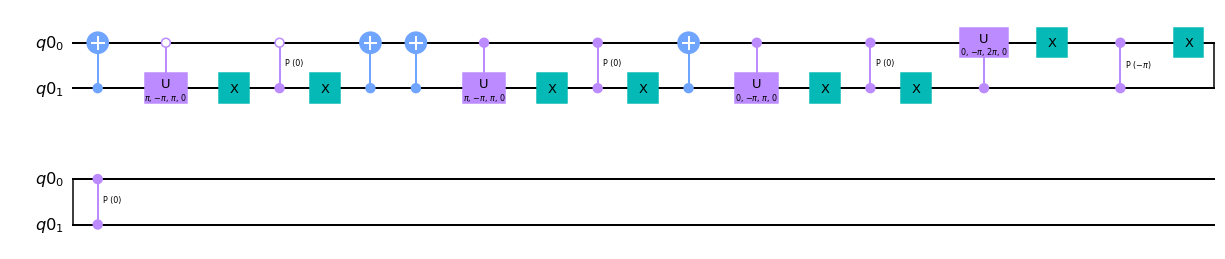

In [2]:
XX=np.array([[0,0,0,1],[0,0,1,0],[0,1,0,0],[1,0,0,0]])

qr=QuantumRegister(2)
qc=QuantumCircuit(qr)
decomposer(XX, qc, qr)
qc.draw(output='mpl')

In [3]:
backend = Aer.get_backend('unitary_simulator')
job = execute(qc, backend)
u = np.asarray(job.result().get_unitary())
print("Frobenius norm of difference between given unitary and result:",np.linalg.norm(XX-u))

Frobenius norm of difference between given unitary and result: 3.240110874435164e-16


#### Decomposition of $F_3 \oplus I_1$
- implement the $3x3$ Fourier transform $F_3$ on two qubits
- use the basis states $|00\rangle$, $|01\rangle$ and $|10\rangle$ and identity on $|11\rangle$

In [4]:
f3i1=np.zeros((4,4),dtype=complex)
w3=np.exp(-2*math.pi*1j/3)
for i in range(3):
    for j in range(3):
        f3i1[i][j]=w3**(i*j)/math.sqrt(3)
f3i1[3][3]=1
print(f3i1)

[[ 0.57735027+0.j   0.57735027+0.j   0.57735027+0.j   0.        +0.j ]
 [ 0.57735027+0.j  -0.28867513-0.5j -0.28867513+0.5j  0.        +0.j ]
 [ 0.57735027+0.j  -0.28867513+0.5j -0.28867513-0.5j  0.        +0.j ]
 [ 0.        +0.j   0.        +0.j   0.        +0.j   1.        +0.j ]]


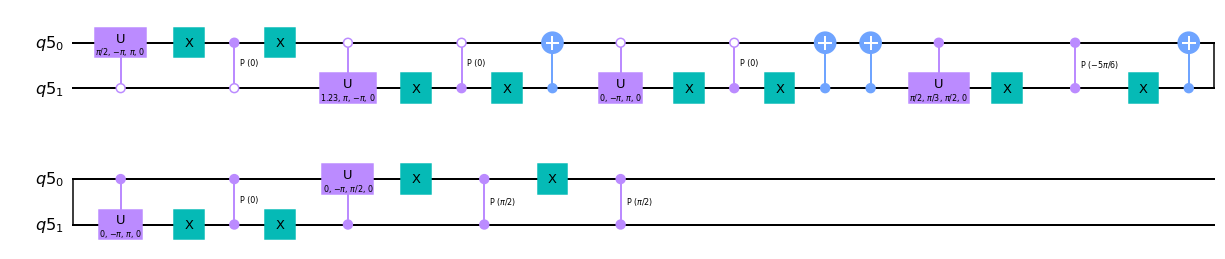

In [5]:
qr=QuantumRegister(2)
qc=QuantumCircuit(qr)
decomposer(f3i1, qc, qr)
qc.draw(output='mpl')

In [6]:
backend = Aer.get_backend('unitary_simulator')
job = execute(qc, backend)
u = np.asarray(job.result().get_unitary())
print("Frobenius norm of difference between given unitary and result:",np.linalg.norm(f3i1-u))

Frobenius norm of difference between given unitary and result: 5.849090849383115e-16


#### Decompose the unitary of a random circuit

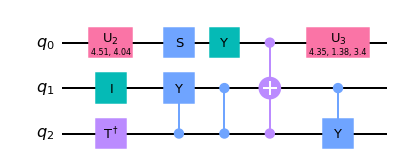

In [7]:
from qiskit.circuit.random import random_circuit
num_qubits=3
depth=5
qc=random_circuit(num_qubits, depth)
display(qc.draw(output='mpl'))

# Get the unitary matrix that corresponds to this circuit.
backend = Aer.get_backend('unitary_simulator')
job = execute(qc, backend)
uOriginal = np.asarray(job.result().get_unitary())

In [8]:
qr=QuantumRegister(num_qubits)
qc=QuantumCircuit(qr)
decomposer(uOriginal, qc, qr)

# Get the unitary matrix that corresponds to this circuit.
backend = Aer.get_backend('unitary_simulator')
job = execute(qc, backend)
uConstruct = np.asarray(job.result().get_unitary())
print("Frobenius norm of difference between given unitary and result:",np.linalg.norm(uOriginal-uConstruct))

Frobenius norm of difference between given unitary and result: 1.5131275966355945e-14


#### State preparation
- we can use the method ``circuitStateVector`` for creating a circuit for a unitary $U$
- the unitary $U^\dagger$ prepares the given state from the state $|0\rangle \otimes \ldots \otimes |0\rangle$

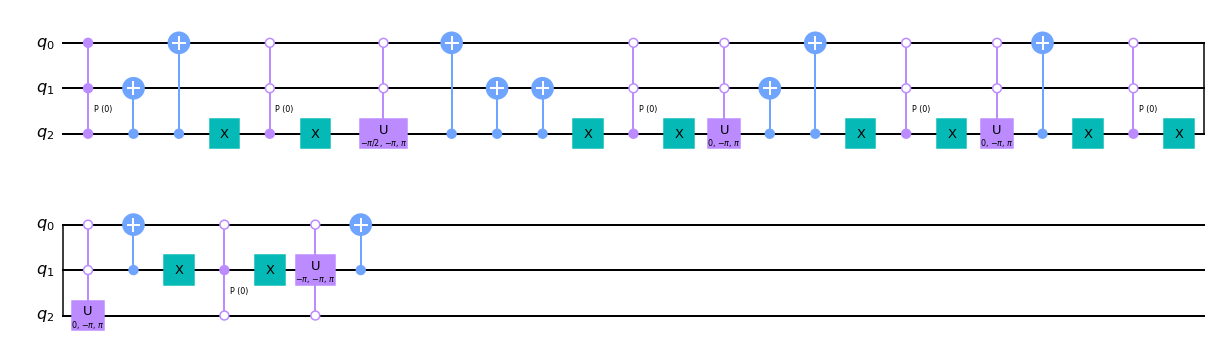

Frobenius norm of difference between given state and constructed state: 3.3528803450785237e-15


In [9]:
qubits=3
vOriginal=[0,0,0,1/math.sqrt(2),0,0,0,1/math.sqrt(2)]

# Create custom gate from unitary U.
qr=QuantumRegister(qubits,'q')
qc=QuantumCircuit(qr)
circuitStateVector(vOriginal,qc, qr)
gate=qc.to_gate()

# Apply U^dagger to create state v.
qr2=QuantumRegister(qubits,'q')
qc2=QuantumCircuit(qr2)
qc2.append(gate.inverse(),qr2)
display(qc2.decompose().draw(output='mpl'))
backend=Aer.get_backend('statevector_simulator')
job=execute(qc2,backend)
vReproduce=np.asarray(job.result().get_statevector())

print("Frobenius norm of difference between given state and constructed state:",np.linalg.norm(vOriginal-vReproduce))

the original vector: [(0.09958912374443361+0.155452466794305j), (0.4286273310670349+0.6008257507474303j), (0.32028784969492935+0.11139681958322122j), (0.1232374268637825+0.5394650534048095j)]


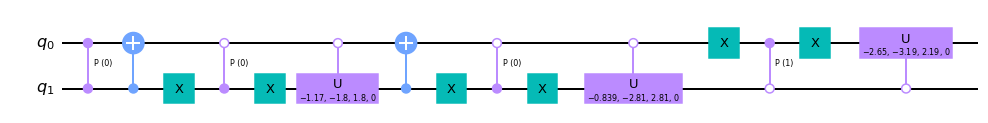

Frobenius norm of difference between given state and constructed state: 2.5814177514652363e-16


In [10]:
#
# Create circuit for a random state vector.
#
qubits=2
v=[random.random()+1j*random.random() for x in range(2**qubits)]
vNormed=[x/np.linalg.norm(v) for x in v]
print("the original vector:",vNormed)

# Create custom gate from unitary U
qr=QuantumRegister(qubits,'q')
qc=QuantumCircuit(qr)
circuitStateVector(vNormed,qc, qr)
gate=qc.to_gate()

# Apply U^dagger to create state v.
qr2=QuantumRegister(qubits,'q')
qc2=QuantumCircuit(qr2)
qc2.append(gate.inverse(),qr2)
display(qc2.decompose().draw(output='mpl'))
backend=Aer.get_backend('statevector_simulator')
job=execute(qc2,backend)
vReproduce=np.asarray(job.result().get_statevector())

print("Frobenius norm of difference between given state and constructed state:",np.linalg.norm(vNormed-vReproduce))